In [1]:
import os
import timm
import json
import torch
import numpy as np
import pandas as pd
from torch import nn
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import torch.optim as optim
from torchvision import transforms
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
GLOBAL_SEED=123
np.random.seed(GLOBAL_SEED)

In [3]:
kaggle_root = Path('/kaggle/input')
dataset_root = kaggle_root / 'imaterialist-fashion-2020-fgvc7'
models_root = kaggle_root / 'saved-models-imaterialist-embedding-extraction'
train_df_path = dataset_root / 'train.csv'
# images_folder = dataset_root / 'train'
images_folder = kaggle_root / 'imaterialist-train-224x224' / 'train_224'
desc_path = dataset_root / 'label_descriptions.json'

In [4]:
full_dataset_df = pd.read_csv(train_df_path)

In [5]:
full_dataset_groupped = full_dataset_df[
    ['ImageId', 'ClassId']
].groupby('ImageId')[
    'ClassId'
].agg([('ClassIds', lambda xs: set(xs))])

In [6]:
N_CLASSES=len(set(full_dataset_df['ClassId']))
print("Number of classes: ", N_CLASSES)

Number of classes:  46


In [7]:
class_descriptions = json.load(open(desc_path))
class_descriptions = list(map(lambda x: x[1], sorted(list(map(
    lambda x: (x['id'], x['name']),
    class_descriptions['categories']
)), key=lambda x: x[0])))
class_descriptions = np.array(class_descriptions)

In [8]:
class FashionDataset(Dataset):
    def __init__(
            self,
            dataframe,
            image_folder,
            n_classes=N_CLASSES,
            transform=None,
            positive_match_percent=0.8,
            seed_with=None,
            cache_n=None,
        ):
        self.dataframe: pd.DataFrame = dataframe
        self.image_folder: Path = image_folder
        self.transform: nn.Module = transform
        self.n_classes: int = n_classes
        self.labels_images = self.create_label_to_image_series()
        self.positive_match_percent: float = positive_match_percent
        self.all_classes = set(np.arange(N_CLASSES))
        self.seed_with = seed_with
        self.cache_n = cache_n
        self.cached_matches_dict = {}
        if seed_with is not None:
            np.random.seed(seed_with)
        if cache_n is not None:
            print("Caching...")
            for i in tqdm(range(len(self.dataframe))):
                self.update_matches_at_i(i)
    
    def update_matches_at_i(self, i):
        anchor_image_id = self.dataframe.iloc[i].name
        anchor_labels = self.dataframe.iloc[i]['ClassIds']
        
        potential_positives_v_cts = self.labels_images[list(anchor_labels)].explode().value_counts()

        pos_mask = potential_positives_v_cts >= (
            self.positive_match_percent * len(anchor_labels)
        )
        positive_image_is = list(np.random.choice(np.where(pos_mask)[0], self.cache_n))
        positive_image_ids = potential_positives_v_cts.iloc[positive_image_is].index.tolist()

        neg_mask = ((anchor_labels - self.dataframe["ClassIds"]).apply(len) == len(anchor_labels))
        negative_image_is = np.random.choice(np.where(neg_mask)[0], self.cache_n)
        negative_image_ids = self.dataframe.iloc[negative_image_is].index.tolist()

        self.cached_matches_dict[i] = (positive_image_ids, negative_image_ids)

    def __len__(self):
        return len(self.dataframe)

    def create_label_to_image_series(self) -> pd.Series:
        """Regroup by ClassId for quick access in the future"""
        return self.dataframe.explode("ClassIds").groupby("ClassIds").apply(
            lambda x: set(x.index)
        )
    
    def load_transform(self, image_id):
        image = Image.open(self.image_folder / f"{image_id}.jpg")
        if image.mode == 'L':
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_positive_negative(self, anchor_labels):
        potential_positives_v_cts = self.labels_images[list(anchor_labels)].explode().value_counts()

        pos_mask = potential_positives_v_cts >= (
            self.positive_match_percent * len(anchor_labels)
        )
        positive_image_i = np.random.choice(np.where(pos_mask)[0])
        positive_image_id = potential_positives_v_cts.iloc[[positive_image_i]].index[0]

        neg_mask = ((anchor_labels - self.dataframe["ClassIds"]).apply(len) == len(anchor_labels))
        negative_image_i = np.random.choice(np.where(neg_mask)[0])
        negative_image_id = self.dataframe.iloc[negative_image_i].name

        return positive_image_id, negative_image_id

    def __getitem__(self, idx):
        if idx == 0 and self.seed_with is not None:
            np.random.seed(self.seed_with)

        anchor_image_id = self.dataframe.iloc[idx].name
        
        if self.cache_n is None:
            anchor_labels = self.dataframe.iloc[idx]['ClassIds']
            positive_image_id, negative_image_id = self.get_positive_negative(anchor_labels)
        else:
            positive_image_id = self.cached_matches_dict[idx][0].pop()
            negative_image_id = self.cached_matches_dict[idx][1].pop()

        anchor_image = self.load_transform(anchor_image_id)
        positive_image = self.load_transform(positive_image_id)
        negative_image = self.load_transform(negative_image_id)

        return anchor_image, positive_image, negative_image

In [9]:
train_df, test_df = train_test_split(
    full_dataset_groupped,
    test_size=0.2,
    random_state=GLOBAL_SEED,
)

In [10]:
input_size = 224

train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(input_size, scale=(0.33, 1)),
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

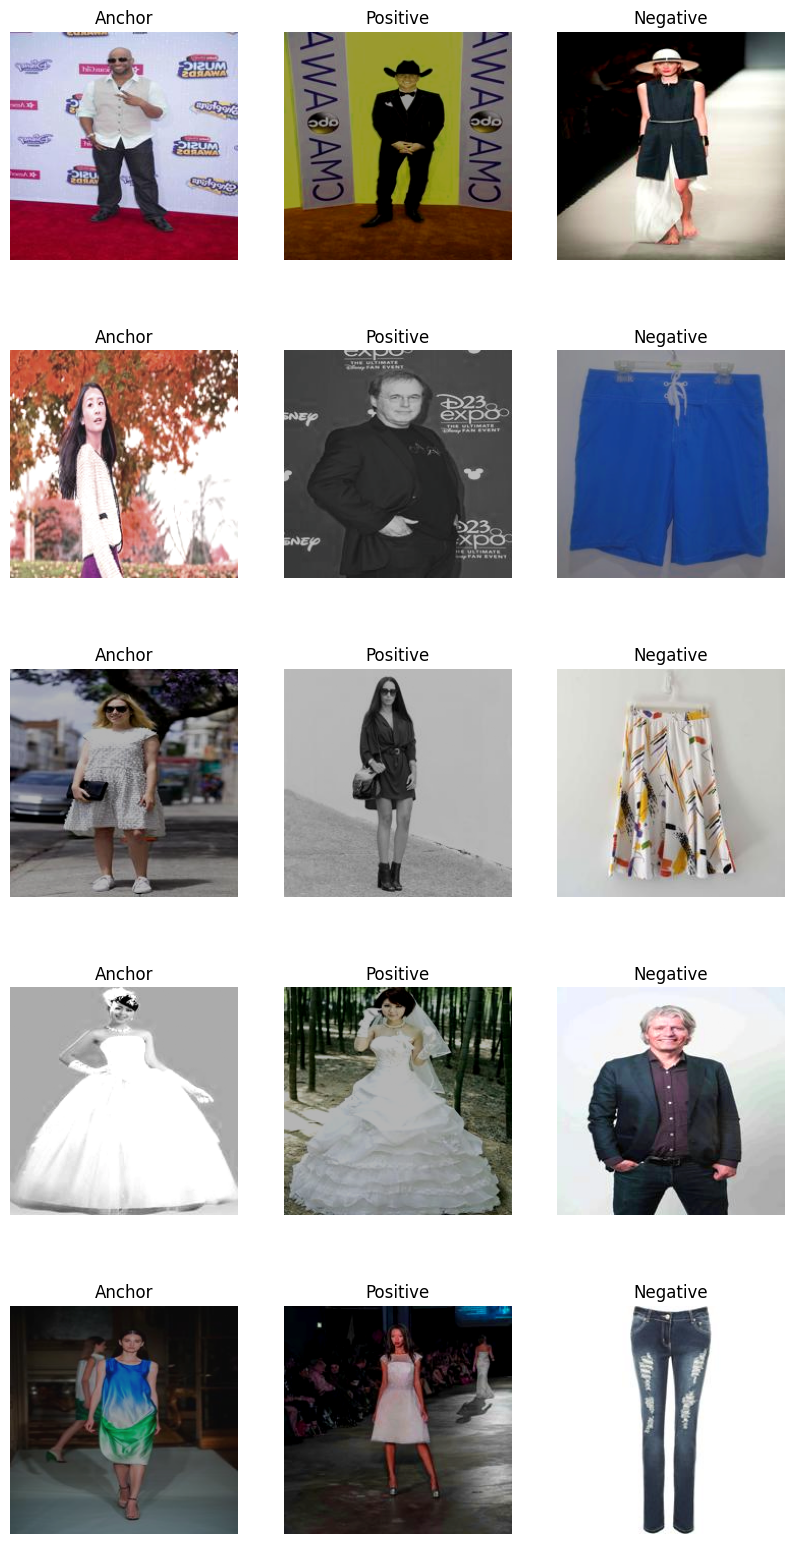

In [11]:
def denorm(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for channel in range(3):
        image[channel] *= std[channel]
        image[channel] += mean[channel]
    return image.permute(1, 2, 0)
    

tds = FashionDataset(train_df, images_folder, transform=train_transform, seed_with=GLOBAL_SEED)
n = 5
fig, axes = plt.subplots(n, 3, figsize=(n*2, 10*2))
for i, ax_row in enumerate(axes):
    anchor, pos, neg = tds[i]
    ax_row[0].imshow(denorm(anchor))
    ax_row[0].set_title("Anchor")
    ax_row[0].axis('off')
    ax_row[1].imshow(denorm(pos))
    ax_row[1].set_title("Positive")
    ax_row[1].axis('off')
    ax_row[2].imshow(denorm(neg))
    ax_row[2].set_title("Negative")
    ax_row[2].axis('off')
plt.show()

In [12]:
N_EPOCHS=20

In [13]:
train_dataset = FashionDataset(train_df, images_folder, transform=train_transform, cache_n=N_EPOCHS)
test_dataset = FashionDataset(test_df, images_folder, transform=test_transform, seed_with=GLOBAL_SEED, cache_n=N_EPOCHS)

Caching...


100%|██████████| 36498/36498 [1:14:57<00:00,  8.12it/s]


Caching...


100%|██████████| 9125/9125 [03:51<00:00, 39.47it/s]


In [14]:
BATCH_SIZE=32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())

In [15]:
model = timm.create_model('swin_small_patch4_window7_224.ms_in22k_ft_in1k', pretrained=True)

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
# model.head.fc = nn.Linear(model.head.fc.in_features, N_CLASSES)
model.head.fc = nn.Identity()

In [17]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

In [19]:
SKIP_EPOCHS = 0 # based on model
# small_trainedhead_path = models_root / 'last_layer_trained_small_swin_ep1_best5237.pth'
# model.load_state_dict(torch.load(small_trainedhead_path, map_location=device))

In [20]:
n_params, n_trained = 0, 0
for name, params in model.named_parameters():
    if 'layers' in name and int(name.split('.')[1]) < 3:
        params.requires_grad = False
#         print(f"Removing {name}")
    elif 'patch_embed' in name:
        params.requires_grad = False
#         print(f"Removing {name}")
    else:
        params.requires_grad = True
        n_trained += params.numel()
        print(f"Keeping {name}")
    n_params += params.numel()
    
print(f"Training {n_trained}/{n_params} ({n_trained/n_params*100:.2f}%)")

Keeping layers.3.downsample.norm.weight
Keeping layers.3.downsample.norm.bias
Keeping layers.3.downsample.reduction.weight
Keeping layers.3.blocks.0.norm1.weight
Keeping layers.3.blocks.0.norm1.bias
Keeping layers.3.blocks.0.attn.relative_position_bias_table
Keeping layers.3.blocks.0.attn.qkv.weight
Keeping layers.3.blocks.0.attn.qkv.bias
Keeping layers.3.blocks.0.attn.proj.weight
Keeping layers.3.blocks.0.attn.proj.bias
Keeping layers.3.blocks.0.norm2.weight
Keeping layers.3.blocks.0.norm2.bias
Keeping layers.3.blocks.0.mlp.fc1.weight
Keeping layers.3.blocks.0.mlp.fc1.bias
Keeping layers.3.blocks.0.mlp.fc2.weight
Keeping layers.3.blocks.0.mlp.fc2.bias
Keeping layers.3.blocks.1.norm1.weight
Keeping layers.3.blocks.1.norm1.bias
Keeping layers.3.blocks.1.attn.relative_position_bias_table
Keeping layers.3.blocks.1.attn.qkv.weight
Keeping layers.3.blocks.1.attn.qkv.bias
Keeping layers.3.blocks.1.attn.proj.weight
Keeping layers.3.blocks.1.attn.proj.bias
Keeping layers.3.blocks.1.norm2.weigh

In [21]:
def train(model, dataloader, criterion, optimizer, device, stop_i=None):
    model.train()
    total_loss = 0
    for i, (anchor, positive, negative) in enumerate(tqdm(dataloader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_embed = model(anchor)
        positive_embed = model(positive)
        negative_embed = model(negative)

        loss = criterion(anchor_embed, positive_embed, negative_embed)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        if stop_i is not None and i > stop_i: break

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [22]:
def test(model, dataloader, criterion, device, stop_i=None):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for i, (anchor, positive, negative) in enumerate(tqdm(dataloader)):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_embed = model(anchor)
            positive_embed = model(positive)
            negative_embed = model(negative)

            loss = criterion(anchor_embed, positive_embed, negative_embed)
            total_loss += loss.item()

            correct_predictions += (
                (anchor_embed - positive_embed).pow(2).sum(1) <
                (anchor_embed - negative_embed).pow(2).sum(1)
            ).sum().item()
            total_predictions += anchor.size(0)

            if stop_i is not None and i > stop_i: break

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_predictions
    return avg_loss, accuracy

In [23]:
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=0.00001)

In [24]:
num_epochs = N_EPOCHS
max_acc = 0
stop_i = None
for epoch in range(num_epochs):
    if epoch < SKIP_EPOCHS:
        print(f"\nSKIPPED: Epoch {epoch+1}/{num_epochs}")
        scheduler.step()
        continue
    train_loss = train(model, train_loader, criterion, optimizer, device, stop_i=stop_i)
    test_loss, test_acc = test(model, test_loader, criterion, device, stop_i=stop_i)
    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test accuracy: {test_acc:.6f}")
    postfix = f'ep{epoch+1}'
    if test_acc > max_acc:
        print("Detected new best test accuracy!")
        max_acc = test_acc
        postfix += f'_best{test_acc*10000:.0f}'
    print("Saving model!")
    torch.save(model.state_dict(), f'/kaggle/working/model_{postfix}.pth')
    scheduler.step()
    print()

100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 1/20, Train Loss: 0.1509, Test Loss: 0.1125, Test accuracy: 0.958247
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 2/20, Train Loss: 0.1076, Test Loss: 0.0908, Test accuracy: 0.965918
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 3/20, Train Loss: 0.0945, Test Loss: 0.0932, Test accuracy: 0.965918
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.31it/s]



Epoch 4/20, Train Loss: 0.0832, Test Loss: 0.0865, Test accuracy: 0.968438
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 5/20, Train Loss: 0.0737, Test Loss: 0.0917, Test accuracy: 0.966685
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 6/20, Train Loss: 0.0677, Test Loss: 0.0856, Test accuracy: 0.968767
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.31it/s]



Epoch 7/20, Train Loss: 0.0584, Test Loss: 0.0893, Test accuracy: 0.968110
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.31it/s]



Epoch 8/20, Train Loss: 0.0517, Test Loss: 0.0854, Test accuracy: 0.969644
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 9/20, Train Loss: 0.0465, Test Loss: 0.0832, Test accuracy: 0.969096
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 10/20, Train Loss: 0.0393, Test Loss: 0.0834, Test accuracy: 0.970959
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 11/20, Train Loss: 0.0329, Test Loss: 0.0799, Test accuracy: 0.971397
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 12/20, Train Loss: 0.0293, Test Loss: 0.0849, Test accuracy: 0.971397
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 13/20, Train Loss: 0.0239, Test Loss: 0.0806, Test accuracy: 0.972493
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 14/20, Train Loss: 0.0203, Test Loss: 0.0773, Test accuracy: 0.973699
Detected new best test accuracy!
Saving model!



100%|██████████| 286/286 [02:03<00:00,  2.31it/s]



Epoch 15/20, Train Loss: 0.0167, Test Loss: 0.0794, Test accuracy: 0.972932
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 16/20, Train Loss: 0.0141, Test Loss: 0.0772, Test accuracy: 0.972712
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 17/20, Train Loss: 0.0124, Test Loss: 0.0803, Test accuracy: 0.972603
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 18/20, Train Loss: 0.0108, Test Loss: 0.0791, Test accuracy: 0.972055
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 19/20, Train Loss: 0.0089, Test Loss: 0.0778, Test accuracy: 0.972493
Saving model!



100%|██████████| 286/286 [02:04<00:00,  2.30it/s]



Epoch 20/20, Train Loss: 0.0084, Test Loss: 0.0784, Test accuracy: 0.972055
Saving model!

